In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark import SparkConf

In [2]:
import pandas as pd
import time
import praw
import pytz
from datetime import datetime
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, ArrayType
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from geotext import GeoText

In [3]:
# Create SparkSession with 2 cores
spark = SparkSession.builder.appName("Data Processing").config("spark.executor.instances", 2).getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/18 22:23:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
start_time = time.time()  # Record the start time


In [5]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

In [6]:

# Set up Reddit API credentials
client_id = "##################"
client_secret = "###################"
user_agent = "script by u/HellRuler8055"

# Authenticate with Reddit API
reddit = praw.Reddit(client_id=client_id,
                     client_secret=client_secret,
                     user_agent=user_agent)

# Define the subreddit and query parameters
subreddit_name = "crime"
limit = 200

# Extract relevant data from Reddit
subreddit = reddit.subreddit(subreddit_name)
posts = subreddit.new(limit=limit)



# Extract data from the API response
data = []
for post in posts:
    data.append({
        "id": post.id,
        "name": post.name,
        "title": post.title,
        "body": post.selftext,
        "created_utc": post.created_utc,
        "upvote_count" : post.score,
        "comment_count" : post.num_comments,
    })
    




In [7]:
data

[{'id': '13lal4u',
  'name': 't3_13lal4u',
  'title': 'What the data says about gun deaths in the U.S.',
  'body': '',
  'created_utc': 1684443295.0,
  'upvote_count': 1,
  'comment_count': 0},
 {'id': '13l3jbo',
  'name': 't3_13l3jbo',
  'title': 'Nathaniel Veltman',
  'body': 'What is the status of this case?',
  'created_utc': 1684427058.0,
  'upvote_count': 1,
  'comment_count': 0},
 {'id': '13l1yw8',
  'name': 't3_13l1yw8',
  'title': 'Mojave Desert mass shooting mystery: A desperate text, slaughter in an RV, many questions',
  'body': '',
  'created_utc': 1684423321.0,
  'upvote_count': 2,
  'comment_count': 0},
 {'id': '13l1xlg',
  'name': 't3_13l1xlg',
  'title': 'Dozens of LASD deputies ordered to show suspected gang tattoos, reveal others who have them',
  'body': '',
  'created_utc': 1684423232.0,
  'upvote_count': 2,
  'comment_count': 0},
 {'id': '13l1mzx',
  'name': 't3_13l1mzx',
  'title': '12-year-old armed with AR-style gun kills Sonic employee in Dallas-area, police s

In [8]:

# Convert the extracted data to a Pandas DataFrame
pandas_df = pd.DataFrame(data)

# Convert the Pandas DataFrame to a Spark DataFrame
df = spark.createDataFrame(pandas_df)


In [9]:
df

id,name,title,body,created_utc,upvote_count,comment_count
13lal4u,t3_13lal4u,What the data say...,,1.684443295E9,1,0
13l3jbo,t3_13l3jbo,Nathaniel Veltman,What is the statu...,1.684427058E9,1,0
13l1yw8,t3_13l1yw8,Mojave Desert mas...,,1.684423321E9,2,0
13l1xlg,t3_13l1xlg,Dozens of LASD de...,,1.684423232E9,2,0
13l1mzx,t3_13l1mzx,12-year-old armed...,,1.684422542E9,19,0
13l10sp,t3_13l10sp,Police video of I...,,1.684421014E9,3,0
13l0ntb,t3_13l0ntb,‘Let’s call it wh...,,1.684420099E9,2,0
13klb3k,t3_13klb3k,Elizabeth Holmes ...,,1.684375374E9,24,1
13kjynr,t3_13kjynr,PNG Prime Ministe...,,1.684371745E9,6,0
13k90qv,t3_13k90qv,Who is BTK aka De...,,1.684346043E9,1,1


In [10]:
def convert_utc_to_local(utc_timestamp):
    localized_time = datetime.utcfromtimestamp(float(utc_timestamp)).replace(tzinfo=pytz.utc).astimezone(pytz.timezone('America/New_York'))
    return localized_time.strftime('%Y-%m-%d %H:%M:%S')

In [11]:
# Register the conversion function as a UDF
convert_utc_to_local_udf = udf(convert_utc_to_local, StringType())

# Apply the UDF to the 'created_utc' column
df = df.withColumn('created_utc', convert_utc_to_local_udf('created_utc'))


In [12]:
df

id,name,title,body,created_utc,upvote_count,comment_count
13lal4u,t3_13lal4u,What the data say...,,2023-05-18 16:54:55,1,0
13l3jbo,t3_13l3jbo,Nathaniel Veltman,What is the statu...,2023-05-18 12:24:18,1,0
13l1yw8,t3_13l1yw8,Mojave Desert mas...,,2023-05-18 11:22:01,2,0
13l1xlg,t3_13l1xlg,Dozens of LASD de...,,2023-05-18 11:20:32,2,0
13l1mzx,t3_13l1mzx,12-year-old armed...,,2023-05-18 11:09:02,19,0
13l10sp,t3_13l10sp,Police video of I...,,2023-05-18 10:43:34,3,0
13l0ntb,t3_13l0ntb,‘Let’s call it wh...,,2023-05-18 10:28:19,2,0
13klb3k,t3_13klb3k,Elizabeth Holmes ...,,2023-05-17 22:02:54,24,1
13kjynr,t3_13kjynr,PNG Prime Ministe...,,2023-05-17 21:02:25,6,0
13k90qv,t3_13k90qv,Who is BTK aka De...,,2023-05-17 13:54:03,1,1


In [13]:
df.describe()

23/05/18 22:24:19 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


summary,id,name,title,body,created_utc,upvote_count,comment_count
count,200,200,200,200,200,200,200
mean,null,null,null,null,null,13.495,2.14
stddev,null,null,null,null,null,15.920972388929176,4.354908280395037
min,133zzhr,t3_133zzhr,'Corruption toll'...,,2023-04-30 14:58:46,0,0
max,13lal4u,t3_13lal4u,’18 times she too...,What’s the best c...,2023-05-18 16:54:55,111,42


In [14]:
def extract_place_name(text):
    places = GeoText(str(text))
    return ', '.join(places.cities + places.countries)

# Register the function as a UDF
extract_place_udf = udf(extract_place_name, StringType())

# Apply the UDF to create the 'place' column
df = df.withColumn('place', extract_place_udf(df['title']))

In [15]:
df

id,name,title,body,created_utc,upvote_count,comment_count,place
13lal4u,t3_13lal4u,What the data say...,,2023-05-18 16:54:55,1,0,
13l3jbo,t3_13l3jbo,Nathaniel Veltman,What is the statu...,2023-05-18 12:24:18,1,0,
13l1yw8,t3_13l1yw8,Mojave Desert mas...,,2023-05-18 11:22:01,2,0,
13l1xlg,t3_13l1xlg,Dozens of LASD de...,,2023-05-18 11:20:32,2,0,
13l1mzx,t3_13l1mzx,12-year-old armed...,,2023-05-18 11:09:02,19,0,
13l10sp,t3_13l10sp,Police video of I...,,2023-05-18 10:43:34,3,0,Police
13l0ntb,t3_13l0ntb,‘Let’s call it wh...,,2023-05-18 10:28:19,2,0,
13klb3k,t3_13klb3k,Elizabeth Holmes ...,,2023-05-17 22:02:54,24,1,
13kjynr,t3_13kjynr,PNG Prime Ministe...,,2023-05-17 21:02:25,6,0,
13k90qv,t3_13k90qv,Who is BTK aka De...,,2023-05-17 13:54:03,1,1,


In [16]:
df.dropna()

id,name,title,body,created_utc,upvote_count,comment_count,place
13lal4u,t3_13lal4u,What the data say...,,2023-05-18 16:54:55,1,0,
13l3jbo,t3_13l3jbo,Nathaniel Veltman,What is the statu...,2023-05-18 12:24:18,1,0,
13l1yw8,t3_13l1yw8,Mojave Desert mas...,,2023-05-18 11:22:01,2,0,
13l1xlg,t3_13l1xlg,Dozens of LASD de...,,2023-05-18 11:20:32,2,0,
13l1mzx,t3_13l1mzx,12-year-old armed...,,2023-05-18 11:09:02,19,0,
13l10sp,t3_13l10sp,Police video of I...,,2023-05-18 10:43:34,3,0,Police
13l0ntb,t3_13l0ntb,‘Let’s call it wh...,,2023-05-18 10:28:19,2,0,
13klb3k,t3_13klb3k,Elizabeth Holmes ...,,2023-05-17 22:02:54,24,1,
13kjynr,t3_13kjynr,PNG Prime Ministe...,,2023-05-17 21:02:25,6,0,
13k90qv,t3_13k90qv,Who is BTK aka De...,,2023-05-17 13:54:03,1,1,


In [17]:

place = df.groupBy("place").count().orderBy('count', ascending=False).show(10)
place


+--------+-----+
|   place|count|
+--------+-----+
|        |  128|
|     Man|    5|
|  Police|    5|
|   Texas|    5|
| Chicago|    4|
|  Oregon|    3|
| Georgia|    3|
|   Sudan|    2|
|Oklahoma|    2|
| Phoenix|    1|
+--------+-----+
only showing top 10 rows



In [18]:
df[['place']].show(200)

+------------------+
|             place|
+------------------+
|                  |
|                  |
|                  |
|                  |
|                  |
|            Police|
|                  |
|                  |
|                  |
|                  |
|           Nigeria|
|                  |
|                  |
|                  |
|                  |
|                  |
|                  |
|                  |
|               Man|
|            Oaxaca|
|            Police|
|                  |
|                  |
|                  |
|           Phoenix|
|                  |
|      Indianapolis|
|                  |
|  Detroit, Detroit|
|                  |
|              Puno|
|                  |
|                  |
|                  |
|                  |
|      Philadelphia|
|                  |
|                  |
|                  |
|                  |
|           Chicago|
|            Oregon|
|            Oregon|
|                  |
|            

In [19]:
df = df.filter((df.place != ''))
  
# examine the dataframe
df.show()

+-------+----------+--------------------+----+-------------------+------------+-------------+----------------+
|     id|      name|               title|body|        created_utc|upvote_count|comment_count|           place|
+-------+----------+--------------------+----+-------------------+------------+-------------+----------------+
|13l10sp|t3_13l10sp|Police video of I...|    |2023-05-18 10:43:34|           3|            0|          Police|
|13k2434|t3_13k2434|Gunmen attack the...|    |2023-05-17 09:41:52|           3|            1|         Nigeria|
|13jplg3|t3_13jplg3|Man arrested for ...|    |2023-05-16 23:06:54|           5|            2|             Man|
|13jlnzc|t3_13jlnzc|Another attack: T...|    |2023-05-16 20:09:28|           8|            0|          Oaxaca|
|13jhen2|t3_13jhen2|Police: Father ki...|    |2023-05-16 17:13:21|          15|            3|          Police|
|13j5nut|t3_13j5nut|Phoenix PD scramb...|    |2023-05-16 09:44:51|           4|            0|         Phoenix|
|

In [20]:
df_clean = df.filter((df.place != 'Police')&(df.place != 'Goodyear')&(df.place!='Man')&(df.place!='Of'))
  

In [21]:
df_clean

id,name,title,body,created_utc,upvote_count,comment_count,place
13k2434,t3_13k2434,Gunmen attack the...,,2023-05-17 09:41:52,3,1,Nigeria
13jlnzc,t3_13jlnzc,Another attack: T...,,2023-05-16 20:09:28,8,0,Oaxaca
13j5nut,t3_13j5nut,Phoenix PD scramb...,,2023-05-16 09:44:51,4,0,Phoenix
13itroz,t3_13itroz,Indianapolis offi...,,2023-05-15 23:31:23,6,1,Indianapolis
13ishyf,t3_13ishyf,Detroit police pr...,,2023-05-15 22:32:55,5,0,"Detroit, Detroit"
13io2sl,t3_13io2sl,Valorous police o...,,2023-05-15 19:21:00,4,1,Puno
13iidu3,t3_13iidu3,14-year-old shot ...,,2023-05-15 15:50:09,13,0,Philadelphia
13i3int,t3_13i3int,Shooting on Chica...,,2023-05-15 05:46:17,0,0,Chicago
13hxxq9,t3_13hxxq9,Ex-board member o...,,2023-05-15 00:48:07,8,0,Oregon
13hxufu,t3_13hxufu,Hundreds of Orego...,,2023-05-15 00:43:49,6,0,Oregon


In [22]:

place = df_clean.groupBy("place").count().orderBy('count', ascending=False).show(10)
place



+----------------+-----+
|           place|count|
+----------------+-----+
|           Texas|    5|
|         Chicago|    4|
|          Oregon|    3|
|         Georgia|    3|
|           Sudan|    2|
|        Oklahoma|    2|
|         Phoenix|    1|
|          Dallas|    1|
|          DeKalb|    1|
|Detroit, Detroit|    1|
+----------------+-----+
only showing top 10 rows



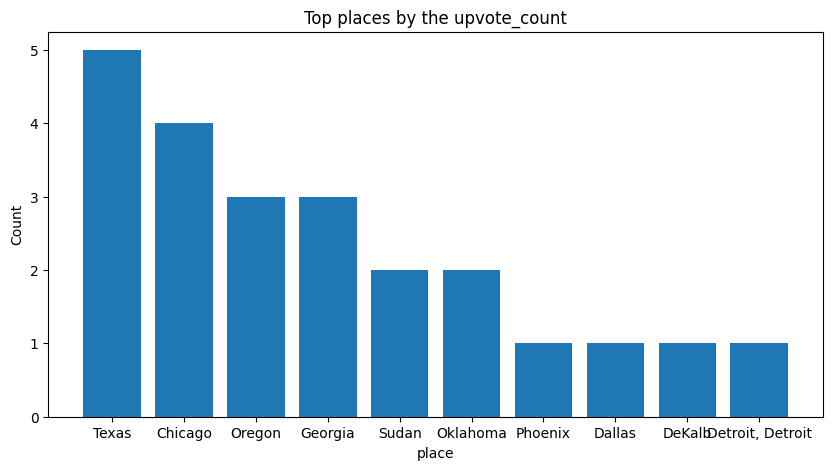

In [23]:



labels = [row['place'] for row in df_clean.groupBy("place").count().orderBy('count', ascending=False).take(10)]
values = [row['count'] for row in df_clean.groupBy("place").count().orderBy('count', ascending=False).take(10)]


plt.figure(figsize=(10, 5))
plt.bar(labels, values)
plt.title('Top places by the upvote_count')
plt.xlabel('place')
plt.ylabel('Count')
plt.show()

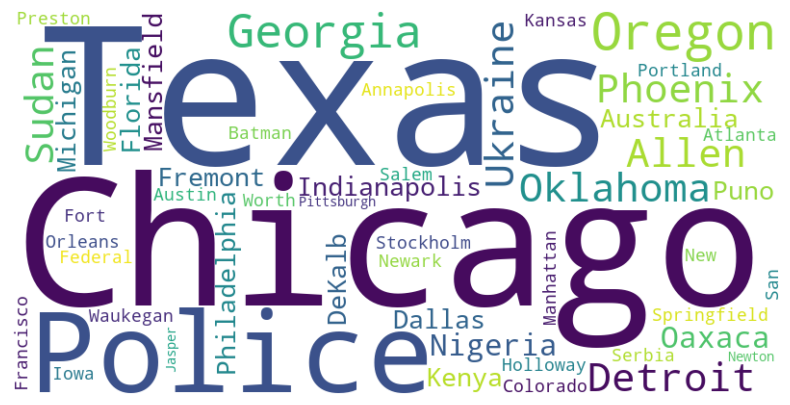

In [24]:



# Extract the "place" column and convert it to an RDD of strings
places = df_clean.select('place').rdd.flatMap(lambda x: x).filter(lambda x: x is not None).map(lambda x: str(x))

# Join all places into a single string
all_places = ' '.join(places.collect())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_places)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



In [25]:
from pyspark.sql.functions import col


grouped_df = df.groupBy('place').sum('upvote_count')

# Rename the sum column
grouped_df = grouped_df.withColumnRenamed('sum(upvote_count)', 'total_upvotes')

# Sort the DataFrame by 'total_upvotes' in descending order
sorted_df = grouped_df.orderBy(col('total_upvotes').desc())

# Show the result
sorted_df.show()


+------------------+-------------+
|             place|total_upvotes|
+------------------+-------------+
|             Texas|          112|
|               Man|           92|
|            Police|           81|
|           Florida|           70|
|     San Francisco|           63|
|         Australia|           49|
|           Georgia|           49|
|          Michigan|           47|
|            DeKalb|           41|
|Police, Fort Worth|           38|
|      Allen, Texas|           36|
|          Oklahoma|           31|
|    Newton, Jasper|           26|
|        Pittsburgh|           26|
|            Serbia|           25|
|             Sudan|           23|
|          Colorado|           19|
|           Chicago|           17|
|            Oregon|           16|
|    Austin, Police|           16|
+------------------+-------------+
only showing top 20 rows



In [26]:
from pyspark.sql.functions import min, max
df.select(min(col('upvote_count')), max(col('upvote_count'))).show()

+-----------------+-----------------+
|min(upvote_count)|max(upvote_count)|
+-----------------+-----------------+
|                0|               70|
+-----------------+-----------------+



In [27]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time} seconds")


Total time taken: 64.44708824157715 seconds
